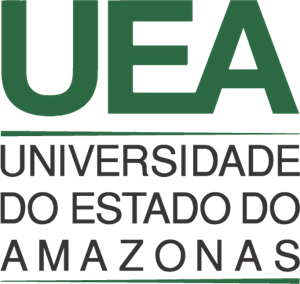

- Módulo: Ciência de Dados para Negócios

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [95]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Install Extra Libraries

In [2]:
# install
!pip install shap
!pip install xgboost
!pip install catboost
!pip install lightgbm

import xgboost
import catboost
import lightgbm as lgb

     |████████████████████████████████| 564 kB 6.7 MB/s 
     |████████████████████████████████| 76.3 MB 1.4 MB/s 


##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [3]:
!pip install kaggle

###Get Files

In [37]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/homesite-quote-conversion
  !kaggle competitions download -c homesite-quote-conversion --force
  !unzip ./test.csv.zip
  !unzip ./train.csv.zip
  !unzip ./sample_submission.csv.zip
  !ls -la ./

In [5]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [38]:
get_data_from_competition()

 69% 17.0M/24.7M [00:00<00:00, 14.8MB/s]
100% 24.7M/24.7M [00:00<00:00, 38.9MB/s]
  0% 0.00/258k [00:00<?, ?B/s]
100% 258k/258k [00:00<00:00, 77.7MB/s]
 78% 29.0M/37.1M [00:00<00:00, 24.2MB/s]
100% 37.1M/37.1M [00:00<00:00, 58.4MB/s]
Archive:  ./test.csv.zip
  inflating: test.csv                
Archive:  ./train.csv.zip
  inflating: train.csv               
Archive:  ./sample_submission.csv.zip
  inflating: sample_submission.csv   
total 402164
drwxr-xr-x 1 root root      4096 Dec 12 19:08 .
drwxr-xr-x 1 root root      4096 Dec 12 17:08 ..
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 2 root root      4096 Dec 12 17:38 .ipynb_checkpoints
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root   1520192 Nov  4  2015 sample_submission.csv
-rw-r--r-- 1 root root    264355 Dec 12 19:08 sample_submission.csv.zip
-rw-r--r-- 1 root root 137849053 Nov  4  2015 test.csv
-rw-r--r-- 1 root root  25927745 Dec 12 19:08 test.csv.zip
-rw-r--r-- 1 root root

In [36]:
!unzip ./test.csv.zip
!ls -la

Archive:  ./test.csv.zip
   skipping: test.csv                unable to get password
total 52724
drwxr-xr-x 1 root root     4096 Dec 12 17:45 .
drwxr-xr-x 1 root root     4096 Dec 12 17:08 ..
drwxr-xr-x 4 root root     4096 Dec  3 14:33 .config
drwxr-xr-x 2 root root     4096 Dec 12 17:38 .ipynb_checkpoints
drwxr-xr-x 1 root root     4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root  7885930 Oct 16  2015 sample_submission.csv
-rw-r--r-- 1 root root   262423 Dec 12 17:45 sample_submission.csv.zip
-rw-r--r-- 1 root root  5567973 Dec 12 17:45 test.csv.zip
-rw-r--r-- 1 root root 34515194 Oct 16  2015 train.csv
-rw-r--r-- 1 root root  5722860 Dec 12 17:45 train.csv.zip


##Datasets


###Initial view

In [39]:
df_dados_teste = pd.read_csv('./test.csv')
df_dados_treino = pd.read_csv('./train.csv')
df_template_sub = pd.read_csv('./sample_submission.csv')

In [107]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

def plot_target_distribution(df_aux):
  print(df_aux['QuoteConversion_Flag'].value_counts())
  plt.figure(figsize = (6,4))
  plt.margins(.2)
  ax = sns.countplot(x = 'QuoteConversion_Flag', 
                    data = df_aux)
  x_labels = ['Não', 'Sim']
  ax.set_xticklabels(x_labels)
  ax.set_title('Cotações de seguro de Casa')
  ax.set_xlabel('Cotações')
  ax.set_ylabel('Qtd. de cotações')
  # plt.xticks(rotation=45)
  add_value_labels(ax)
  plt.show() 

def add_value_labels(ax, spacing=5):
    # reference: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        label = "{:1.1f}K".format(y_value*0.001)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

def fill_na_values(df, value):
  return df.fillna(value)

def split_data_for_xy_columns(df, col_begin, col_end, target):
  split_X = df.loc[:,col_begin:col_end]
  split_y = df.loc[:,target]
  return split_X, split_y 

# Reference: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# Feature Importance
def get_columns_by_importance(X, y, number_col):
  model = ExtraTreesClassifier()
  model.fit(X,y)
  #use inbuilt class feature_importances of tree based classifiers
  # print(model.feature_importances_)
  #plot graph of feature importances for better visualization
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  columns = feat_importances.nlargest(number_col)
  columns.plot(kind='barh')
  plt.show()
  return columns.index

Dados de Treino

In [41]:
df_dados_treino.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicFie

0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64


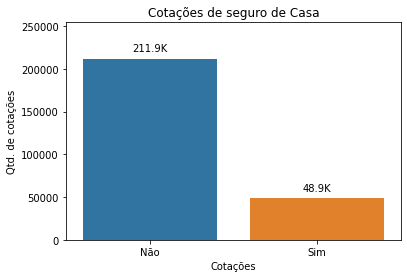

In [79]:
plot_target_distribution(df_dados_treino)

In [81]:
#Remove columns
rm_columns = [ 'Original_Quote_Date' ]

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

In [82]:
explore_dataset(df_dados_treino)

(260753, 298)
--------------------
       QuoteNumber  QuoteConversion_Flag     Field7     Field8    Field9  \
count    260753.00             260753.00  260753.00  260753.00  260753.0   
mean     217201.25                  0.19      18.29       0.94       0.0   
std      125478.52                  0.39       7.38       0.04       0.0   
min           1.00                  0.00       1.00       0.87       0.0   
25%      108517.00                  0.00      11.00       0.92       0.0   
50%      217012.00                  0.00      23.00       0.94       0.0   
75%      325905.00                  0.00      24.00       0.97       0.0   
max      434588.00                  1.00      28.00       1.01       0.0   

         Field11  CoverageField1A  CoverageField1B  CoverageField2A  \
count  260753.00        260753.00        260753.00        260753.00   
mean        1.16             9.01            13.00             9.05   
std         0.12             5.58             7.22             5.56

In [85]:
fields_to_tranform = [
                      'Field6',
                      'Field10',
                      'Field12',
                      'CoverageField8',
                      'CoverageField9',
                      'SalesField7',
                      'PersonalField7',
                      'PersonalField16',
                      'PersonalField17',
                      'PersonalField18',
                      'PersonalField19',
                      'PropertyField3',
                      'PropertyField4',
                      'PropertyField5',
                      'PropertyField7',
                      'PropertyField14',
                      'PropertyField28',
                      'PropertyField30',
                      'PropertyField31',
                      'PropertyField32',
                      'PropertyField33',
                      'PropertyField34',
                      'PropertyField36',
                      'PropertyField37',
                      'PropertyField38',
                      'GeographicField63',
                      'GeographicField64'
                      ]
                      
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

In [97]:
# fill na with median
df_dados_treino = fill_na_values(df_dados_treino, df_dados_treino.median())
df_dados_teste = fill_na_values(df_dados_teste, df_dados_teste.median())

In [98]:
#Check fields in dataset before run
X, y = split_data_for_xy_columns(df_dados_treino,'Field6', 'GeographicField64', target='QuoteConversion_Flag')

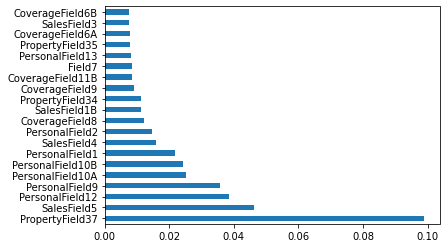

In [108]:
columns_important = get_columns_by_importance(X, y, 20)

In [110]:
print(columns_important.values)

['PropertyField37' 'SalesField5' 'PersonalField12' 'PersonalField9'
 'PersonalField10A' 'PersonalField10B' 'PersonalField1' 'SalesField4'
 'PersonalField2' 'CoverageField8' 'SalesField1B' 'PropertyField34'
 'CoverageField9' 'CoverageField11B' 'Field7' 'PersonalField13'
 'PropertyField35' 'CoverageField6A' 'SalesField3' 'CoverageField6B']


#TODO: continue here

In [91]:
df_dados_treino.head()

,QuoteNumber,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicField36B,GeographicFiel

Dados de Teste

In [ ]:
df_dados_teste.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [ ]:
explore_dataset(df_dados_teste)

(58921, 10)
--------------------
             id   RESOURCE     MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  \
count  58921.00   58921.00   58921.00       58921.00       58921.00   
mean   29461.00   39383.74   26691.65      117028.64      118316.33   
std    17009.17   33717.40   35110.24       10805.45        4284.68   
min        1.00       0.00      25.00        4292.00       23779.00   
25%    14731.00   18418.00    4663.00      117961.00      118096.00   
50%    29461.00   33248.00   14789.00      117961.00      118300.00   
75%    44191.00   45481.00   46512.00      117961.00      118386.00   
max    58921.00  312136.00  311779.00      311178.00      194897.00   

       ROLE_DEPTNAME  ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
count       58921.00    58921.00          58921.00     58921.00   58921.00  
mean       118858.01   126358.02         170455.86    179278.06  119707.75  
std         17916.18    32068.29          69684.69     99639.97    5326.98  
min          4674.0

###TODO - ETL

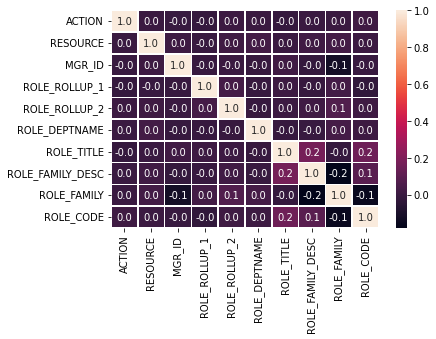

In [12]:
corr = df_dados_treino.corr()
plot = sns.heatmap(corr, annot = True, fmt=".1f", linewidths=.6)
plot

##TODO (atualizar variáveis, o target e demais dependências)- Machine Learning Algorithms

### Utility Functions to help the process

In [ ]:
def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            shuffle = True,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_knn_model(neighbors, X_tr, X_ts, y_tr, y_ts):
  model = KNeighborsClassifier(n_neighbors=neighbors)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def create_tree_model(depth, X_tr, X_ts, y_tr, y_ts):
  tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)

  tree_model.fit(X_tr, y_tr)
  print_model_result(tree_model, X_tr, X_ts, y_tr, y_ts)
  return tree_model

def create_logistic_model(X_tr, X_ts, y_tr, y_ts):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_tr, y_tr)
  print_model_result(logistic_model, X_tr, X_ts, y_tr, y_ts)
  return logistic_model

def create_random_forest_model(depth, estimators, X_tr, X_ts, y_tr, y_ts):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

In [ ]:
def upload_submit(path, msg):
  !kaggle competitions submit -c aml-t2-fw -f '{path}' -m f"Descrição: {msg}"

def send_submit(df, msg):
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  df.to_csv(f'submit_{timestamp}.csv', index=False)
  upload_submit(f'submit_{timestamp}.csv', msg)


def update_df_template(df, df_result_test):
  df['diabetes_mellitus'] = df_result_test.loc[df_result_test['encounter_id'] == df['encounter_id']]['predict']
  return df

def get_dataframe_for_submission(model, prediction_type = None):
  df_result = df_dados_teste.copy()
  print('### Copy Template ###')
  df_result_template = df_template_sub.copy()
  print('### Filter encounter_id column ###\n### Predict ... ###')
  if ( prediction_type is not None ):
    print('### Hard... ###')
    df_result['predict'] = model.predict( df_result[df_result.columns[1:]] )
  else:
    print('### Proba... ###')
    df_result['predict'] = model.predict_proba( df_result[df_result.columns[1:]] )[:,1]
  print('### Create dataframe with result... ###')
  df_result_template = df_result_template.apply(lambda x: update_df_template(x, df_result), axis=1)
  df_result_template = df_result_template.astype({'encounter_id': 'int64'})
  return df_result_template

def view_result(df_result_view):
  df_result_view = round(df_result_view, 2)
  plt.figure(figsize = (16,10))
  ax = sns.countplot(x = 'diabetes_mellitus', 
                    data = df_result_view)

  ax.set_title('Previsão de Pacientes Diabéticos')
  ax.set_xlabel('Diabético')
  ax.set_ylabel('Qtd. de pacientes')
  plt.xticks(rotation=45)
  plt.show()

### Treinamento dos Modelos

The fields which you will filter must be customized based on the treatment applied before.

In [ ]:
#Check fields in dataset before run
X, y = split_data_for_xy_columns(df_dados_treino,'age', 'solid_tumor_with_metastasis', target='diabetes_mellitus')

In [ ]:
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.30, random=1)

Amostras de treino:
 * X_train: (182000, 167)
 * y_train: (182000,)
Amostras de teste:
 * X_test: (78000, 167)
 * y_test: (78000,)


#### KNN - k vizinhos mais próximos
Treino do Modelo utilizando a algoritmo KNN

****************** KNN ******************
Acurácia (Treino): 0.77
Acurácia (Teste): 0.7
              precision    recall  f1-score   support

          NO       0.67      0.79      0.73      7601
         YES       0.74      0.61      0.67      7600

    accuracy                           0.70     15201
   macro avg       0.71      0.70      0.70     15201
weighted avg       0.71      0.70      0.70     15201



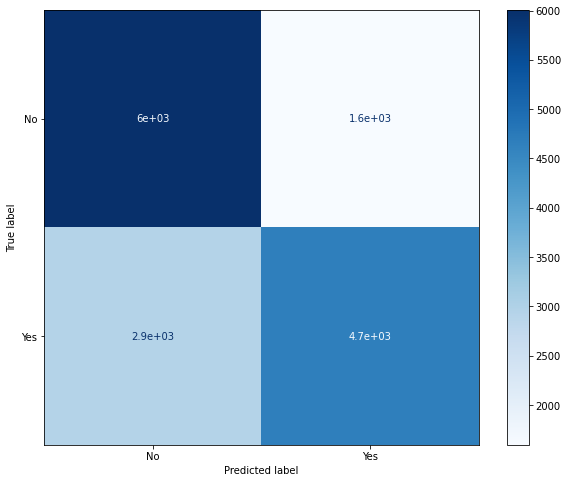

In [ ]:
print('****************** KNN ******************')

knn_model = create_knn_model(neighbors=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


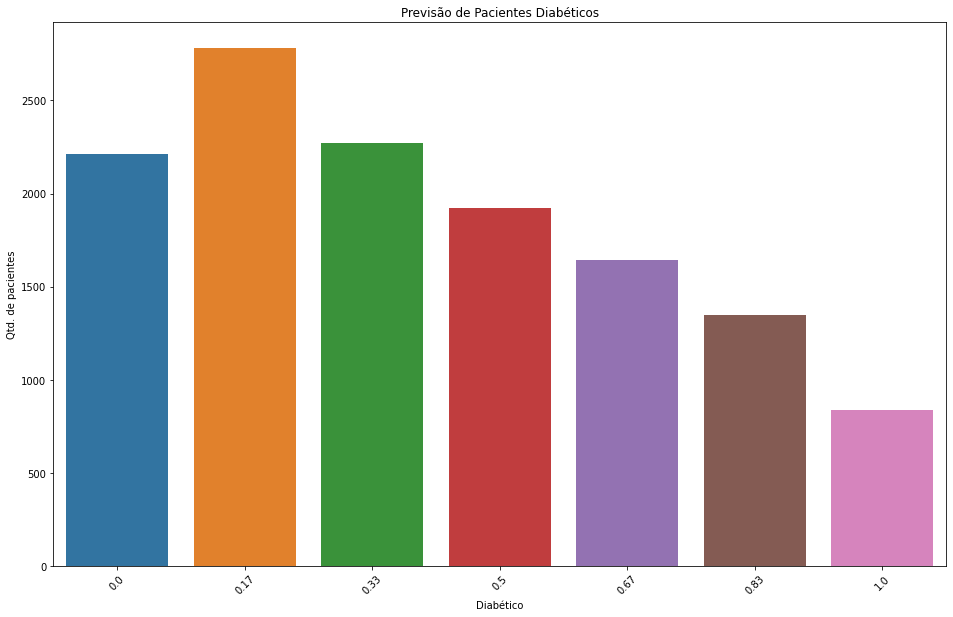

In [ ]:
result_knn = get_dataframe_for_submission(knn_model, prediction_type=None)
view_result(result_knn)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_knn, 'Teste 4 knn')

100%|████████████████████████████████████████| 263k/263k [00:03<00:00, 71.9kB/s]
400 - Bad Request


#### Decision Tree
Treino do Modelo utilizando a algoritmo Árvore de decisão

****************** ARVORE ******************
Acurácia (Treino): 0.81
Acurácia (Teste): 0.8
              precision    recall  f1-score   support

          NO       0.85      0.90      0.88     27543
         YES       0.55      0.43      0.48      7600

    accuracy                           0.80     35143
   macro avg       0.70      0.67      0.68     35143
weighted avg       0.79      0.80      0.79     35143



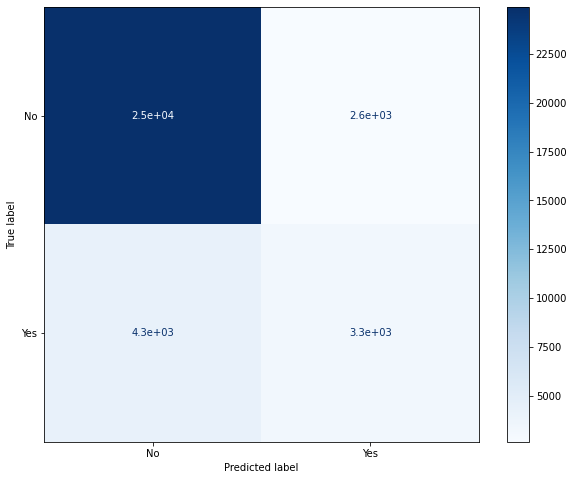

In [ ]:
print('****************** ARVORE ******************')

tree_model = create_tree_model(depth=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


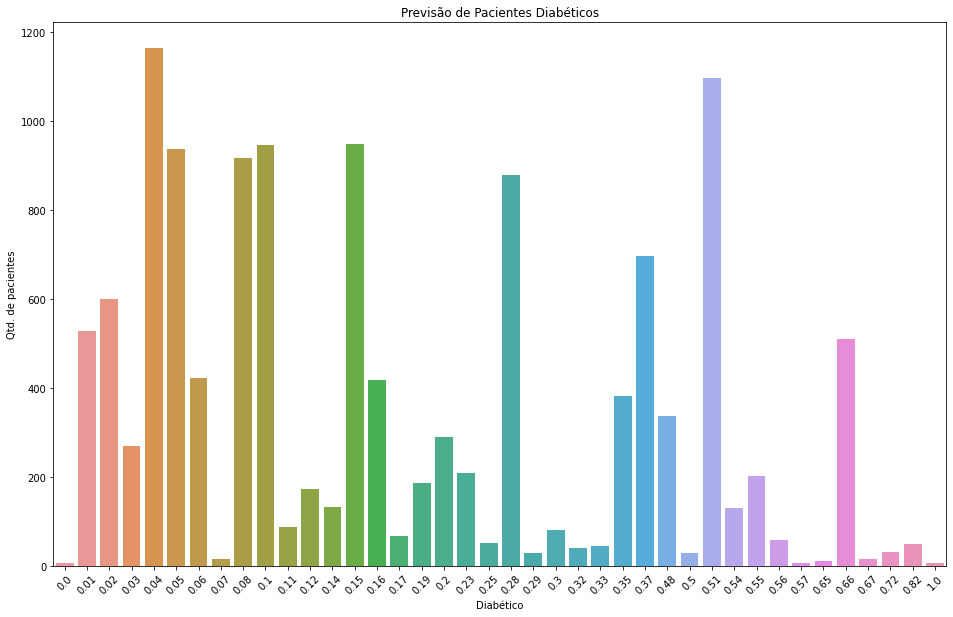

In [ ]:
# gera o df para submissão com base no template
result_tree = get_dataframe_for_submission(tree_model)
view_result(result_tree)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree, 'Teste 5 decision tree')

100%|█████████████████████████████████████████| 339k/339k [00:03<00:00, 106kB/s]
400 - Bad Request


#### Logistic Regression
Treino do Modelo utilizando a algoritmo de Regressão Logística

****************** Regressão Logística ******************
Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.37      0.01      0.02      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.50      0.45     29286
weighted avg       0.69      0.78      0.69     29286



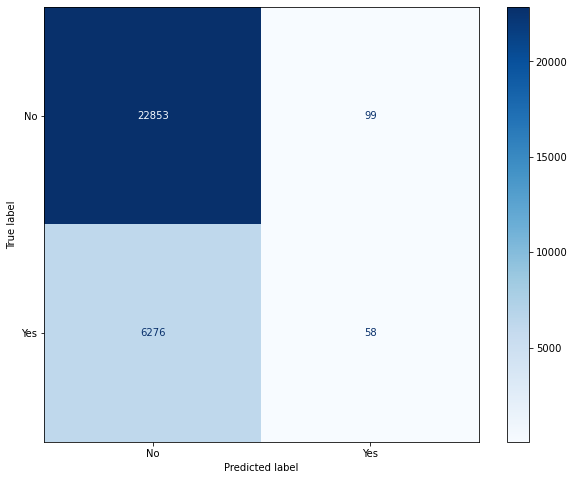

In [ ]:
print('****************** Regressão Logística ******************')

logistic_model = create_logistic_model(X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

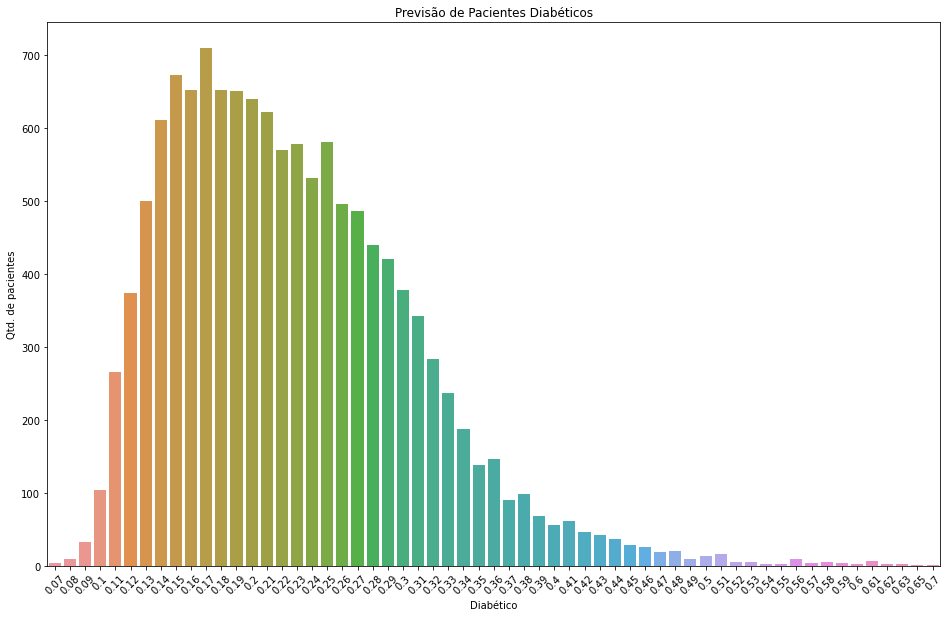

In [ ]:
# gera o df para submissão com base no template
result_logistic = get_dataframe_for_submission(logistic_model)
view_result(result_logistic)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic, 'Teste 2 logistic regression')

100%|█████████████████████████████████████████| 338k/338k [00:03<00:00, 100kB/s]
400 - Bad Request


#### Random Forest
Treino do Modelo utilizando a algoritmo de Random Forest

****************** Random Forest ******************
Acurácia (Treino): 0.93
Acurácia (Teste): 0.82
              precision    recall  f1-score   support

          NO       0.84      0.95      0.89     22952
         YES       0.65      0.33      0.44      6334

    accuracy                           0.82     29286
   macro avg       0.74      0.64      0.66     29286
weighted avg       0.80      0.82      0.79     29286



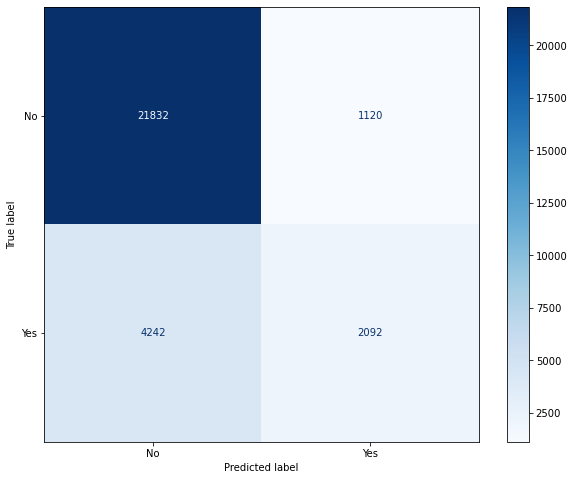

In [ ]:
print('****************** Random Forest ******************')

random_forest_model = create_random_forest_model(depth=16, estimators=100, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

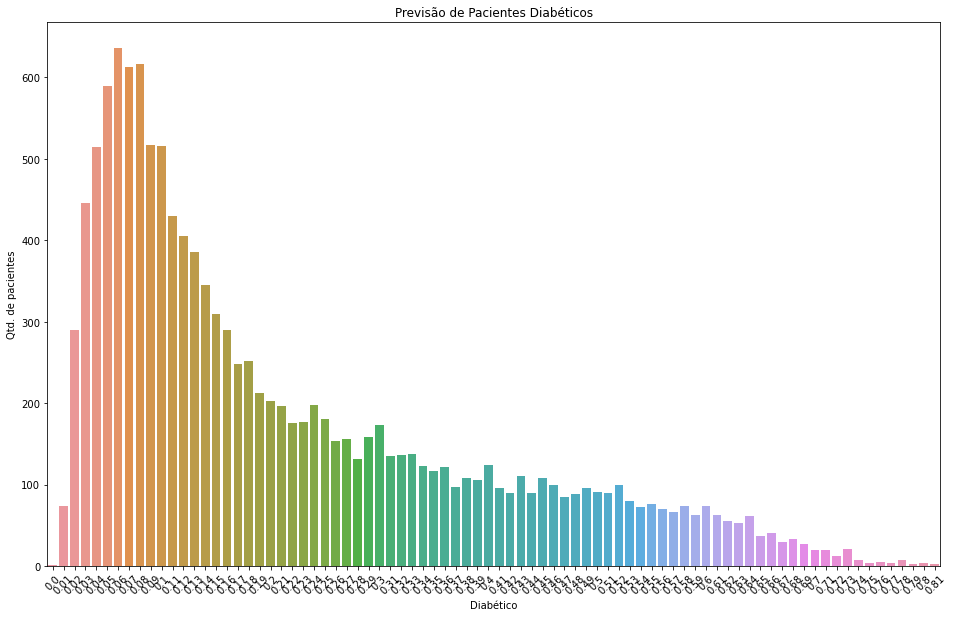

In [ ]:
result_random_forest = get_dataframe_for_submission(random_forest_model)
view_result(result_random_forest)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_random_forest, '9 Random Forest: depth=16, estimators=100')

### Ensemble Learning

Possible metrics to choose

In [ ]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
#@title Choose metric
work_metric = "roc_auc" #@param ["roc_auc", "accuracy"]

Functions to help Ensemble process

In [ ]:
def create_ens_logistic_model():
  model = LogisticRegression()
  return model

def create_ens_decision_tree(depth):
  model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)
  return model

def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')

def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  print('### Fit model ###')
  model.fit(X_tr, y_tr)
  print('### Result: ###')
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

#### Logistic Regression 

In [ ]:
ens_logistic_model = LogisticRegression()

In [ ]:
print('****************** ENSEMBLE Regressão Logística ******************')
ens_logistic_model = create_cross_validation_model(ens_logistic_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Regressão Logística ******************
Cross Validation Result

roc_auc: [0.8036221  0.80789281 0.80401673 0.81187666 0.81392994]

roc_auc (média): 0.8083
roc_auc (desvio padrão): 0.0041


### Fit model ###
### Result: ###
Acurácia (Treino): 0.74
Acurácia (Teste): 0.74
              precision    recall  f1-score   support

          NO       0.73      0.77      0.75     36723
         YES       0.76      0.71      0.73     36723

    accuracy                           0.74     73446
   macro avg       0.74      0.74      0.74     73446
weighted avg       0.74      0.74      0.74     73446



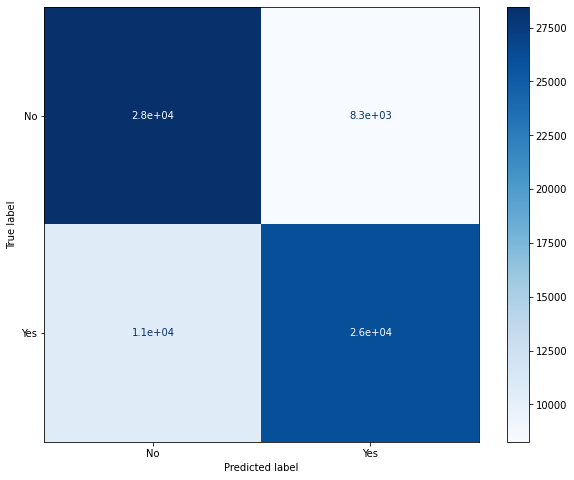

In [ ]:
ens_logistic_model = validate_ens_model(ens_logistic_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


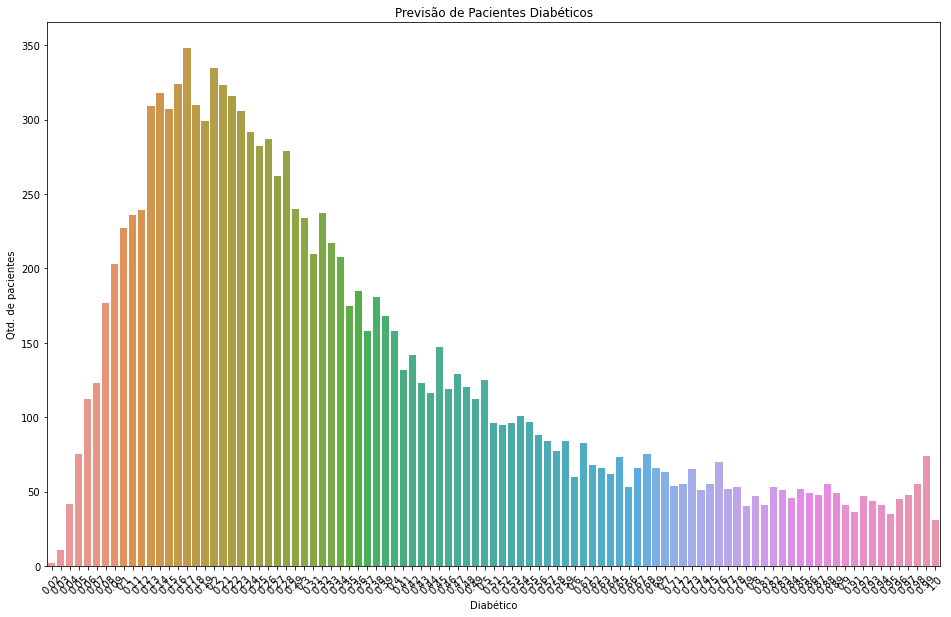

In [ ]:
result_logistic_ens = get_dataframe_for_submission(ens_logistic_model)
view_result(result_logistic_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_logistic_ens, 'Ensemble 2 logistic regression')

#### Decision Tree

In [ ]:
ens_tree_model = create_ens_decision_tree(20)

In [ ]:
print('****************** ENSEMBLE Árvore de Decisão ******************')
ens_tree_model = create_cross_validation_model(ens_tree_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Árvore de Decisão ******************
Cross Validation Result

roc_auc: [0.93326976 0.92972577 0.93574736 0.93188897 0.93740522 0.93201888
 0.93876798 0.93476471 0.93955643 0.93517576]

roc_auc (média): 0.9348
roc_auc (desvio padrão): 0.003


### Fit model ###
### Result: ###
Acurácia (Treino): 0.93
Acurácia (Teste): 0.89
              precision    recall  f1-score   support

          NO       0.94      0.86      0.90     45000
         YES       0.84      0.93      0.88     36000

    accuracy                           0.89     81000
   macro avg       0.89      0.89      0.89     81000
weighted avg       0.89      0.89      0.89     81000



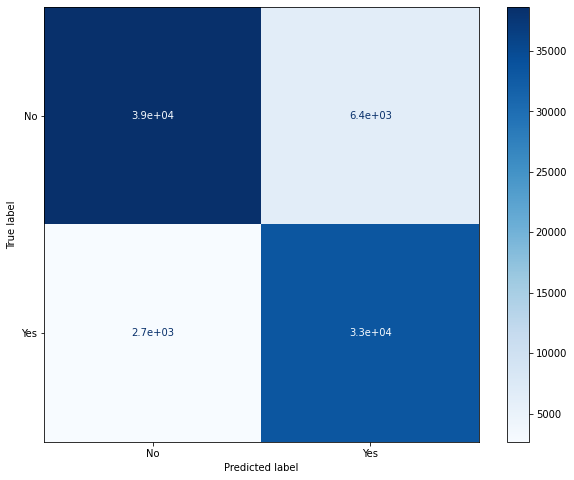

In [ ]:
ens_tree_model = validate_ens_model(ens_tree_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


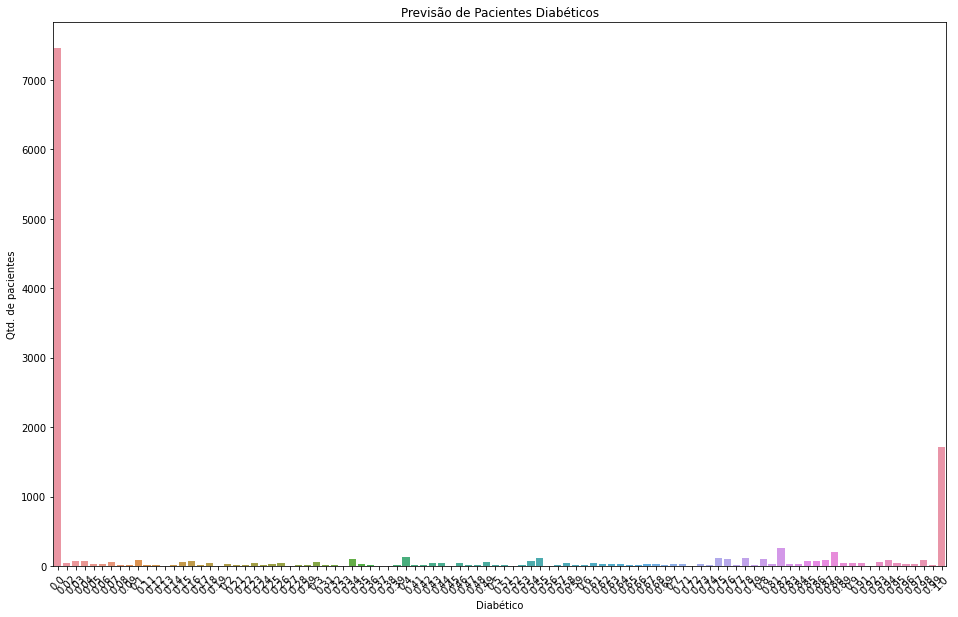

In [ ]:
result_tree_ens = get_dataframe_for_submission(ens_tree_model)
view_result(result_tree_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_tree_ens, 'Ensemble 7 Decision Tree')

100% 182k/182k [00:00<00:00, 593kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Random Forest

In [ ]:
ens_random_forest_model = create_ens_random_forest(16, 100)

In [ ]:
print('****************** ENSEMBLE Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Random Forest ******************
Cross Validation Result

roc_auc: [0.96460368 0.96527394 0.9654582  0.96537982 0.96695957]

roc_auc (média): 0.9655
roc_auc (desvio padrão): 0.0008


### Fit model ###
### Result: ###
Acurácia (Treino): 0.95
Acurácia (Teste): 0.91
              precision    recall  f1-score   support

          NO       0.92      0.91      0.92     42000
         YES       0.90      0.91      0.90     36000

    accuracy                           0.91     78000
   macro avg       0.91      0.91      0.91     78000
weighted avg       0.91      0.91      0.91     78000



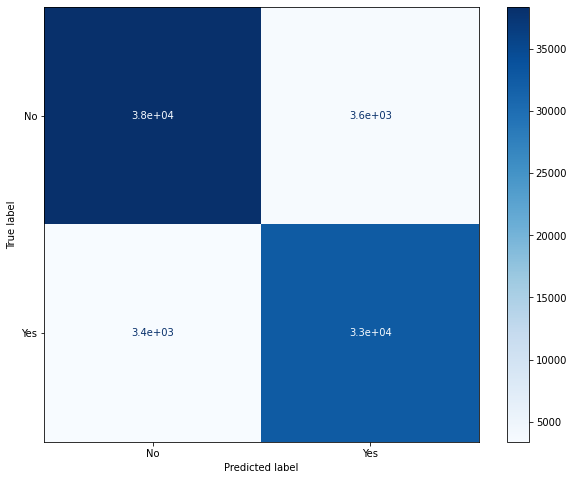

In [ ]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


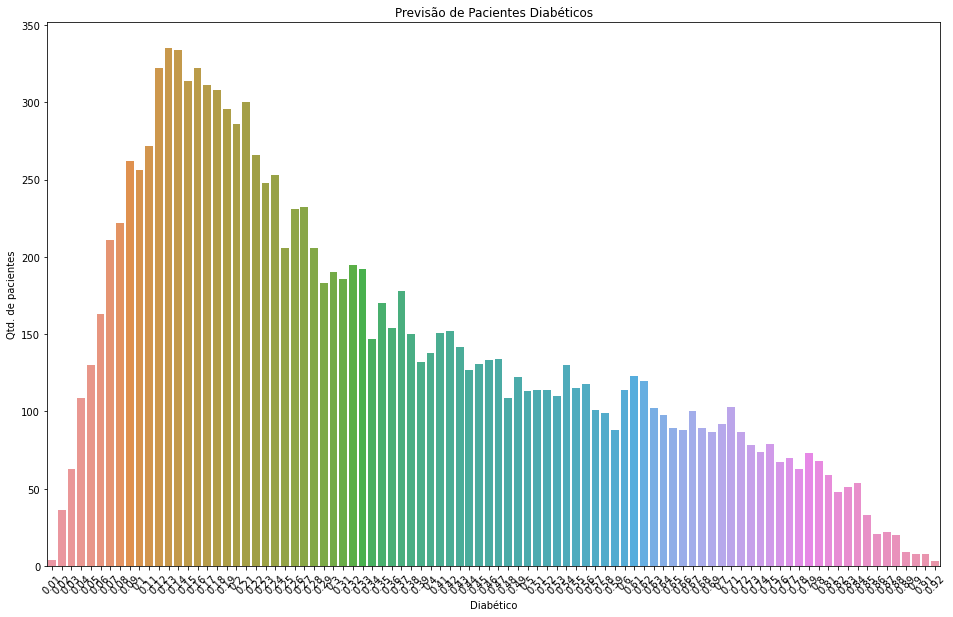

In [ ]:
result_random_forest_ens = get_dataframe_for_submission(ens_random_forest_model)
view_result(result_random_forest_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_random_forest_ens, 'Ensemble 14 Random Forest: depth=16, estimators=100')

100% 336k/336k [00:00<00:00, 1.61MB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Voting Classifier


##### Soft Voting

In [ ]:
# metodos Ensemble Learning
# OBS hard não tem o predic_prob 
def get_voting_classifier(estimators, voting='soft'):
    return VotingClassifier(estimators = estimators, voting=voting)


In [ ]:

soft_voting_model = get_voting_classifier([
                                          #  ('logistic_model', ens_logistic_model),
                                           ('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'soft')

In [ ]:
print('****************** ENSEMBLE Soft Voting Classifier ******************')
soft_voting_model = create_cross_validation_model(soft_voting_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft Voting Classifier ******************
Cross Validation Result

roc_auc: [0.93435569 0.93367492 0.93442905 0.93635558 0.93501065]

roc_auc (média): 0.9348
roc_auc (desvio padrão): 0.0009


### Fit model ###
### Result: ###
Acurácia (Treino): 0.97
Acurácia (Teste): 0.86
              precision    recall  f1-score   support

          NO       0.92      0.78      0.84     36723
         YES       0.81      0.94      0.87     36723

    accuracy                           0.86     73446
   macro avg       0.87      0.86      0.86     73446
weighted avg       0.87      0.86      0.86     73446



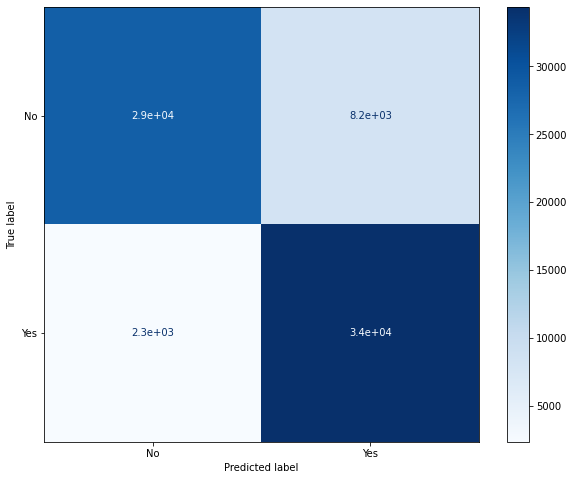

In [ ]:
soft_voting_model = validate_ens_model(soft_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


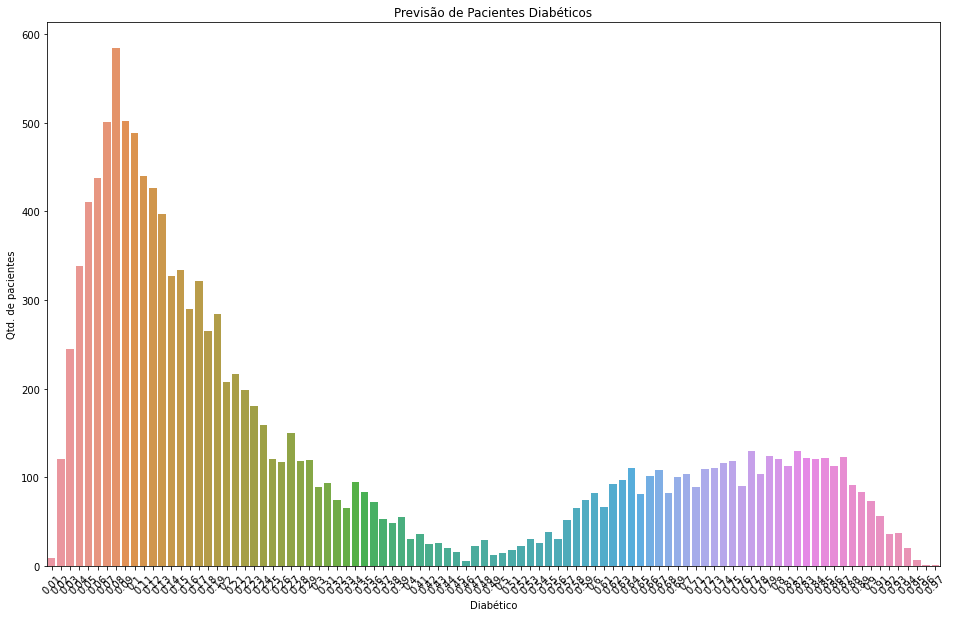

In [ ]:
result_soft_voting = get_dataframe_for_submission(soft_voting_model)
view_result(result_soft_voting)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_soft_voting, 'Ensemble 10 Soft Voting Classifier')

100% 337k/337k [00:03<00:00, 97.9kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Hard Voting

In [ ]:

hard_voting_model = get_voting_classifier([('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'hard')

In [ ]:
print('****************** ENSEMBLE Hard Voting Classifier ******************')
hard_voting_model = create_cross_validation_model(hard_voting_model, 5, 'accuracy', X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Hard Voting Classifier ******************
Cross Validation Result

accuracy: [0.80957384 0.80640925 0.8058839  0.80693459 0.80923299]

accuracy (média): 0.8076
accuracy (desvio padrão): 0.0015


### Fit model ###
### Result: ###
Acurácia (Treino): 0.82
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.83      0.95      0.89     32133
         YES       0.61      0.30      0.40      8867

    accuracy                           0.81     41000
   macro avg       0.72      0.62      0.64     41000
weighted avg       0.78      0.81      0.78     41000



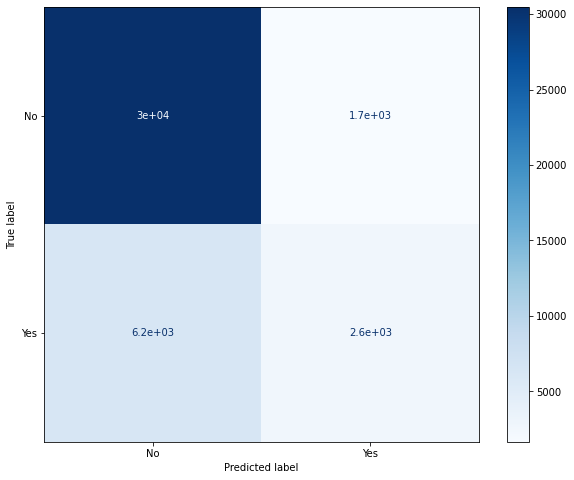

In [ ]:
hard_voting_model = validate_ens_model(hard_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Hard... ###
### Create dataframe with result... ###


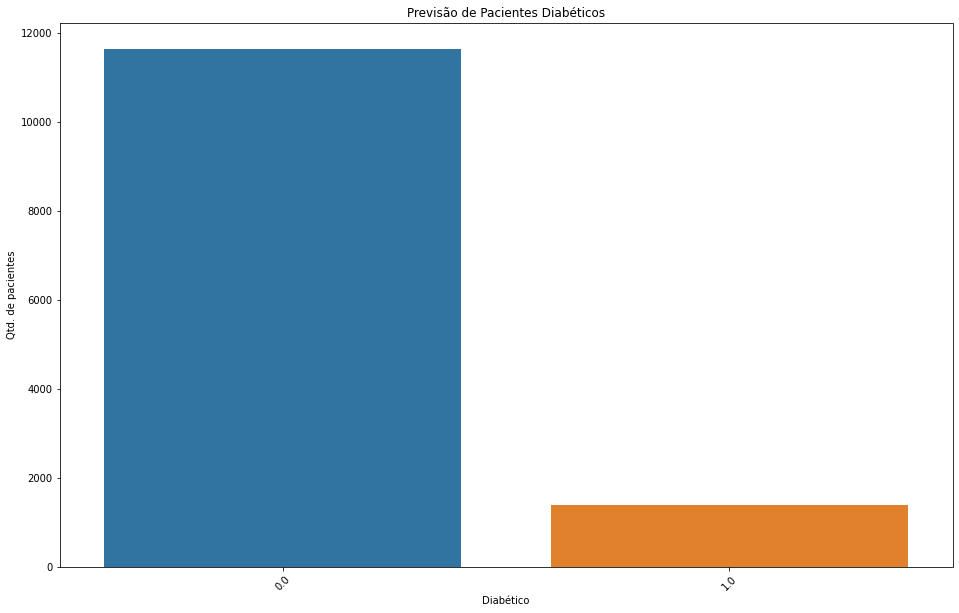

In [ ]:
result_hard_voting = get_dataframe_for_submission(hard_voting_model, prediction_type='predict')
view_result(result_hard_voting)

In [ ]:
# send_submit(result_soft_voting, 'Ensemble 2 Hard Voting Classifier')


#### Boost Methods

##### XGBoost

In [ ]:
# XGBoost
xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
                                  learning_rate = 0.005,
                                  n_estimators = 100,
                                  max_depth = 15,
                                  random_state = 0)


In [ ]:
print('****************** XGBoost ******************')
xgb_model = create_cross_validation_model(xgb_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** XGBoost ******************
Cross Validation Result

roc_auc: [0.92966236 0.92719969 0.93309288 0.93261848 0.93052978]

roc_auc (média): 0.9306
roc_auc (desvio padrão): 0.0021


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.88
              precision    recall  f1-score   support

          NO       0.91      0.87      0.89     45000
         YES       0.84      0.89      0.87     36000

    accuracy                           0.88     81000
   macro avg       0.88      0.88      0.88     81000
weighted avg       0.88      0.88      0.88     81000



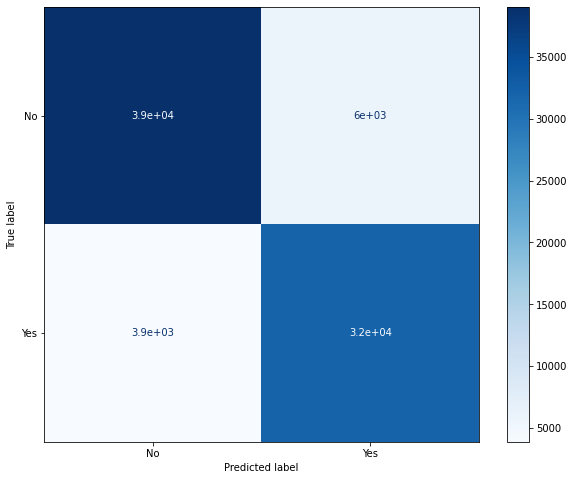

In [ ]:
xgb_model = validate_ens_model(xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


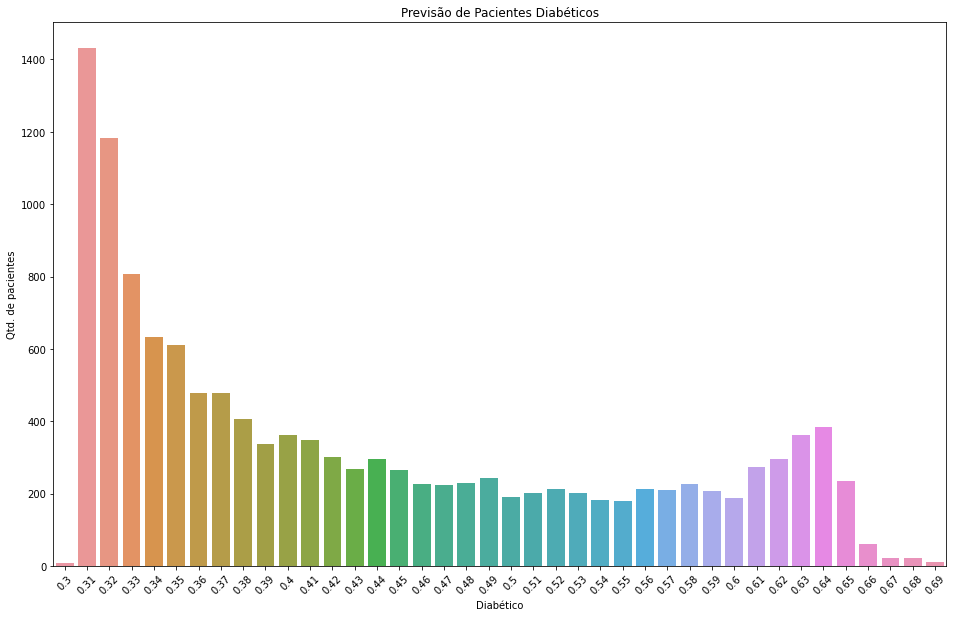

In [ ]:
result_xgb_model = get_dataframe_for_submission(xgb_model)
view_result(result_xgb_model)

In [ ]:
send_submit(result_xgb_model, 'XGBoost 3')

100% 333k/333k [00:05<00:00, 59.5kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

##### CatBoost

In [ ]:
 cat_boost_model = catboost.CatBoostClassifier(iterations=5,
                         learning_rate=0.025,
                         depth=15,
                         random_state=0)

In [ ]:
print('****************** CatBoost ******************')
cat_boost_model = create_cross_validation_model(cat_boost_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** CatBoost ******************
0:	learn: 0.6811417	total: 2.96s	remaining: 11.9s
1:	learn: 0.6697782	total: 5.86s	remaining: 8.8s
2:	learn: 0.6589514	total: 8.77s	remaining: 5.85s
3:	learn: 0.6491694	total: 11.7s	remaining: 2.93s
4:	learn: 0.6396307	total: 14.6s	remaining: 0us
0:	learn: 0.6810912	total: 2.92s	remaining: 11.7s
1:	learn: 0.6696201	total: 5.84s	remaining: 8.76s
2:	learn: 0.6588845	total: 8.73s	remaining: 5.82s
3:	learn: 0.6482411	total: 11.7s	remaining: 2.92s
4:	learn: 0.6390863	total: 14.6s	remaining: 0us
0:	learn: 0.6818497	total: 2.9s	remaining: 11.6s
1:	learn: 0.6705316	total: 5.79s	remaining: 8.69s
2:	learn: 0.6599451	total: 8.7s	remaining: 5.8s
3:	learn: 0.6497243	total: 11.6s	remaining: 2.91s
4:	learn: 0.6400328	total: 14.6s	remaining: 0us
0:	learn: 0.6816427	total: 2.9s	remaining: 11.6s
1:	learn: 0.6699096	total: 5.83s	remaining: 8.75s
2:	learn: 0.6591771	total: 8.75s	remaining: 5.83s
3:	learn: 0.6490072	total: 11.7s	remaining: 2.92s
4:	learn: 0.63

### Fit model ###
0:	learn: 0.6818615	total: 3.12s	remaining: 12.5s
1:	learn: 0.6705648	total: 6.08s	remaining: 9.11s
2:	learn: 0.6597472	total: 9.05s	remaining: 6.04s
3:	learn: 0.6491740	total: 12.1s	remaining: 3.02s
4:	learn: 0.6390572	total: 15.1s	remaining: 0us
### Result: ###
Acurácia (Treino): 0.79
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.80      0.80      0.80     45000
         YES       0.75      0.75      0.75     36000

    accuracy                           0.78     81000
   macro avg       0.78      0.78      0.78     81000
weighted avg       0.78      0.78      0.78     81000



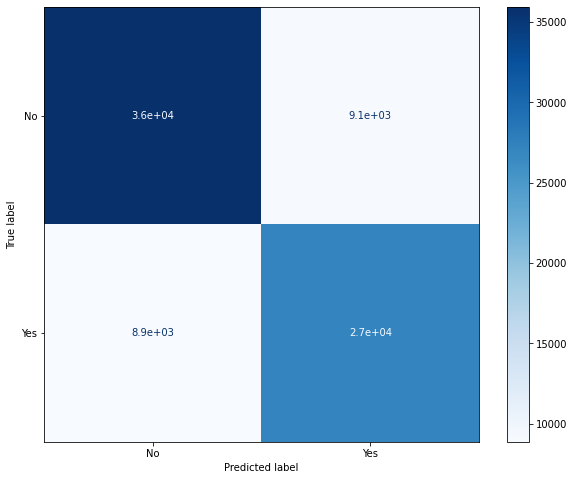

In [ ]:
cat_boost_model = validate_ens_model(cat_boost_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


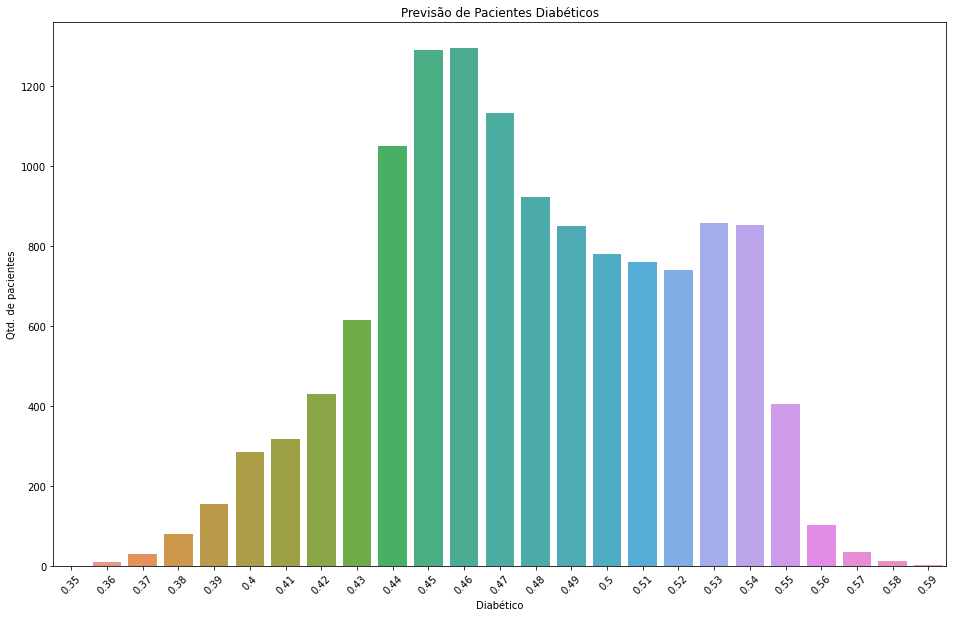

In [ ]:
result_cat_boost_model = get_dataframe_for_submission(cat_boost_model)
view_result(result_cat_boost_model)

In [ ]:
# send_submit(result_cat_boost_model, 'CatBoost')

####Combine Models that use soft vote




In [ ]:
# Soft Models
soft_voting_all_models = get_voting_classifier([
    # ('logistic_model', ens_logistic_model),
    ('xgb_model', xgb_model),
    ('tree_model', ens_tree_model),
    ('cat_boost_model', cat_boost_model),
    ('random_forest_model', ens_random_forest_model)
    ], 'soft')

In [ ]:
print('****************** ENSEMBLE Soft All Models Voting Classifier ******************')
soft_voting_all_models = create_cross_validation_model(soft_voting_all_models, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft All Models Voting Classifier ******************
0:	learn: 0.6811417	total: 3.14s	remaining: 12.6s
1:	learn: 0.6697782	total: 6.14s	remaining: 9.22s
2:	learn: 0.6589514	total: 9.23s	remaining: 6.16s
3:	learn: 0.6491694	total: 12.2s	remaining: 3.04s
4:	learn: 0.6396307	total: 15.2s	remaining: 0us
0:	learn: 0.6810912	total: 3s	remaining: 12s
1:	learn: 0.6696201	total: 6.09s	remaining: 9.14s
2:	learn: 0.6588845	total: 9.22s	remaining: 6.15s
3:	learn: 0.6482411	total: 12.2s	remaining: 3.05s
4:	learn: 0.6390863	total: 15.2s	remaining: 0us
0:	learn: 0.6818497	total: 3.04s	remaining: 12.1s
1:	learn: 0.6705316	total: 6.06s	remaining: 9.09s
2:	learn: 0.6599451	total: 9.1s	remaining: 6.07s
3:	learn: 0.6497243	total: 12.1s	remaining: 3.02s
4:	learn: 0.6400328	total: 15.1s	remaining: 0us
0:	learn: 0.6816427	total: 2.98s	remaining: 11.9s
1:	learn: 0.6699096	total: 5.95s	remaining: 8.92s
2:	learn: 0.6591771	total: 8.89s	remaining: 5.93s
3:	learn: 0.6490072	total: 11.8

### Fit model ###
0:	learn: 0.6818615	total: 3.13s	remaining: 12.5s
1:	learn: 0.6705648	total: 6.12s	remaining: 9.18s
2:	learn: 0.6597472	total: 9.16s	remaining: 6.11s
3:	learn: 0.6491740	total: 12.2s	remaining: 3.06s
4:	learn: 0.6390572	total: 15.3s	remaining: 0us
### Result: ###
Acurácia (Treino): 0.94
Acurácia (Teste): 0.91
              precision    recall  f1-score   support

          NO       0.94      0.88      0.91     45000
         YES       0.87      0.93      0.90     36000

    accuracy                           0.91     81000
   macro avg       0.91      0.91      0.91     81000
weighted avg       0.91      0.91      0.91     81000



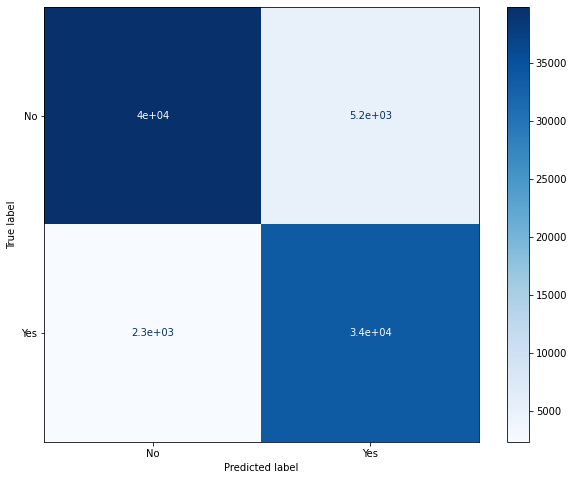

In [ ]:
soft_voting_all_models = validate_ens_model(soft_voting_all_models, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


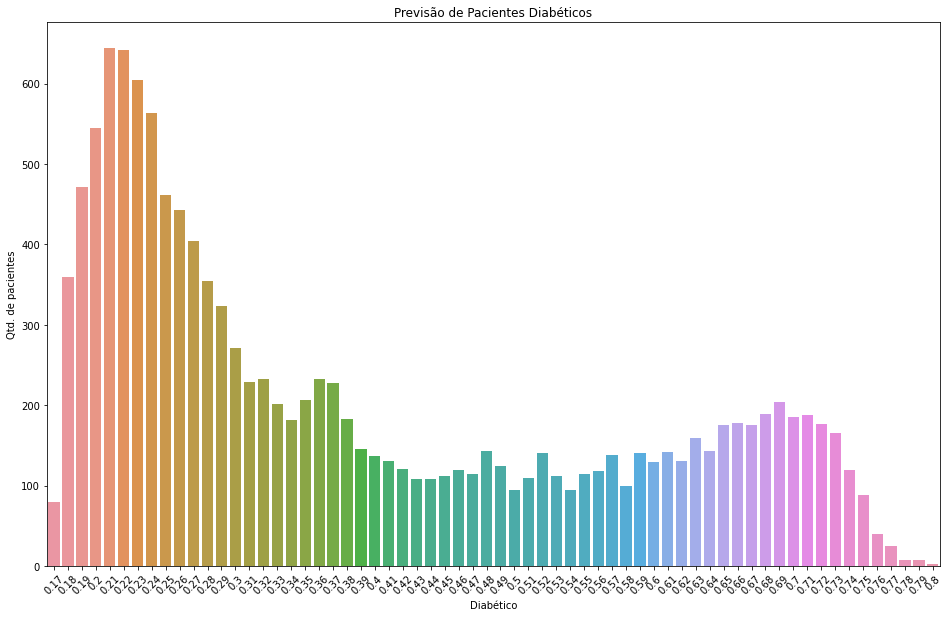

In [ ]:
result_soft_voting_all_models = get_dataframe_for_submission(soft_voting_all_models)
view_result(result_soft_voting_all_models)

In [ ]:
send_submit(result_soft_voting_all_models, 'Soft All Models 10')

100% 335k/335k [00:00<00:00, 1.28MB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

### Redes Neurais

In [ ]:
# Perceptron model
perceptron_model = Perceptron(verbose=0)

In [ ]:
print('****************** Perceptron model Classifier ******************')
perceptron_model = create_cross_validation_model(perceptron_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** Perceptron model Classifier ******************
Cross Validation Result

roc_auc: [0.50057252 0.50742712 0.50835247]

roc_auc (média): 0.5055
roc_auc (desvio padrão): 0.0035


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.00      0.00      0.00      6334

    accuracy                           0.78     29286
   macro avg       0.39      0.50      0.44     29286
weighted avg       0.61      0.78      0.69     29286



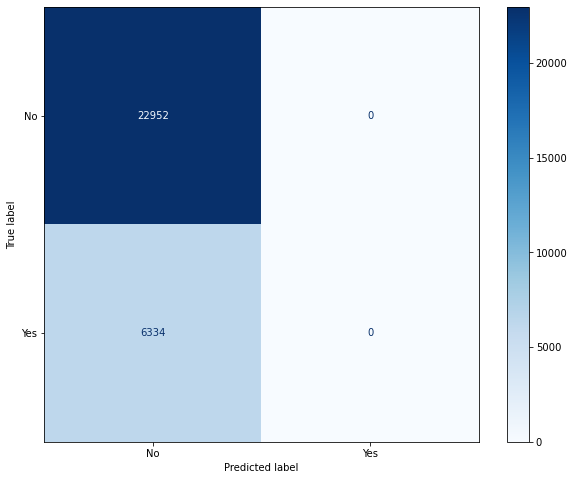

In [ ]:
result_perceptron_model = get_dataframe_for_submission(perceptron_model)

In [ ]:
# send_submit(result_perceptron_model, 'Perceptron model Classifier')

In [ ]:
#Multilayer Perceptron (Scikit-Learn)

mlp_model = MLPClassifier(max_iter=600,
                          random_state=0,
                          verbose=0)

In [ ]:
print('****************** Multilayer Perceptron model Classifier ******************')
mlp_model = create_cross_validation_model(mlp_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** Multilayer Perceptron model Classifier ******************
Cross Validation Result

roc_auc: [0.57029131 0.64663336 0.60019794]

roc_auc (média): 0.6057
roc_auc (desvio padrão): 0.0314


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.58      0.00      0.01      6334

    accuracy                           0.78     29286
   macro avg       0.68      0.50      0.44     29286
weighted avg       0.74      0.78      0.69     29286



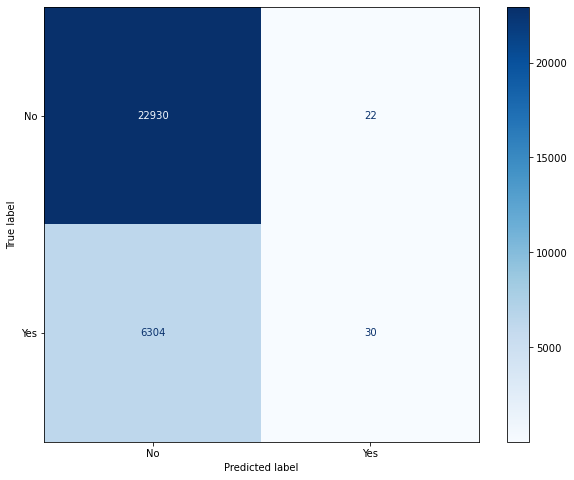

In [ ]:
mlp_model = validate_ens_model(mlp_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [ ]:
result_mlp_model = get_dataframe_for_submission(mlp_model)